In [1]:
import tensorflow


In [2]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 845 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
Note: you may need to restart the kernel to use updated packages.


In [4]:


import numpy as np 
import pandas as pd 
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg19 import VGG19,preprocess_input
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
#from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [5]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [6]:
prev_df = pd.read_csv('../input/isic-2019/ISIC_2019_Training_GroundTruth.csv')

In [7]:
prev_positive = prev_df[prev_df['MEL'] == 1]

In [8]:
import os

In [9]:
old_positive = pd.read_csv("../input/old-positive/old_positive.csv")

In [10]:
old_positive.head()

,image_name,target,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,oldISIC_0000002,1,0,0,0,0,0,0,0,0
1,oldISIC_0000004,1,0,0,0,0,0,0,0,0
2,oldISIC_0000013,1,0,0,0,0,0,0,0,0
3,oldISIC_0000022_downsampled,1,0,0,0,0,0,0,0,0
4,oldISIC_0000026_downsampled,1,0,0,0,0,0,0,0,0


In [11]:
train[train['target'] == 1].shape[0]

584

In [12]:
labels=train['diagnosis'].value_counts().index[1:]
values=train['diagnosis'].value_counts().values[1:]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In [13]:
n = train[train['target'] == 1].shape[0] + old_positive.shape[0]
print(f"total number of positive samples: {n}")

total number of positive samples: 5106


In [14]:
train_positive = train[train['target'] == 1]

In [15]:
train_positive.shape[0]

584

In [16]:
train.shape

(33126, 8)

In [17]:
train[train['target'] == 0].shape

(32542, 8)

In [18]:
train_negative = train[train['target'] == 0].sample(2*n,random_state=111)

In [19]:
train = pd.concat([old_positive, train_positive])

In [20]:
train = pd.concat([train, train_negative])

In [21]:
train.to_csv('downsampled_plus_old.csv')

In [22]:
train['target'].value_counts()

0    10212
1     5106
Name: target, dtype: int64

In [23]:
labels=train['diagnosis'].value_counts().index[1:]
values=train['diagnosis'].value_counts().values[1:]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In [24]:
labels=train['anatom_site_general_challenge'].value_counts().index
values=train['anatom_site_general_challenge'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()


In [25]:
df_0=train[train['target']==0]
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

## Preparing the Datasets

In [26]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [27]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

I'll do some very basic preprocessing like 
* normalizing
* reshaping
* augmentation(only for tarin data)

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False,
    batch_size=8,
    class_mode='raw')



/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning:

Found 3600 invalid image filename(s) in x_col="images". These filename(s) will be ignored.



Found 8654 validated image filenames.
Found 2142 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning:

Found 922 invalid image filename(s) in x_col="images". These filename(s) will be ignored.



## Modelling


In [30]:
def vgg19_model( num_classes=None):

    model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg19_model(1)

80142336/80134624 [==============================] - 3s 0us/step


In [31]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [32]:
opt = Adam(lr=1e-5)
vgg_conv.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [33]:
nb_epochs = 2
batch_size= 45
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 272 and 68


In [34]:
from livelossplot import PlotLossesKeras

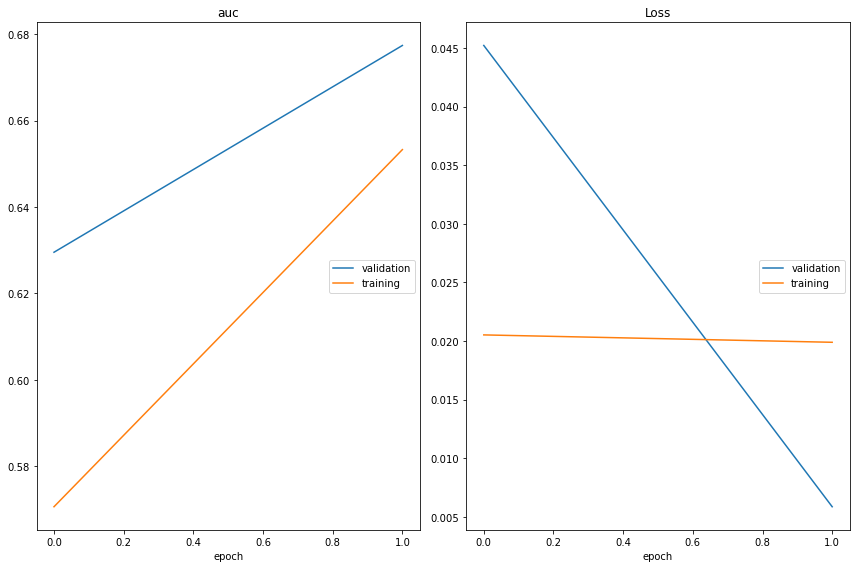

auc
	validation       	 (min:    0.630, max:    0.677, cur:    0.677)
	training         	 (min:    0.571, max:    0.653, cur:    0.653)
Loss
	validation       	 (min:    0.006, max:    0.045, cur:    0.006)
	training         	 (min:    0.020, max:    0.021, cur:    0.020)


In [35]:
cb=[PlotLossesKeras()]
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=nb_val_steps)


**Submission**

In [ ]:
target=[]

for path in df_test['images']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=vgg_conv.predict(img)
    target.append(prediction[0][0])
    
submission['target']=target
    
        

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.head()